## 1. 데이터 준비

### 라이브러리 설치

In [ ]:
!pip install tensorflow

In [ ]:
!pip install autokeras

In [4]:
!pip list

Package                      Version
---------------------------- ---------
absl-py                      1.3.0
astunparse                   1.6.3
autokeras                    1.0.20
backcall                     0.2.0
cachetools                   5.2.0
certifi                      2022.9.24
charset-normalizer           2.1.1
colorama                     0.4.5
debugpy                      1.6.3
decorator                    5.1.1
entrypoints                  0.4
flatbuffers                  22.9.24
gast                         0.4.0
google-auth                  2.13.0
google-auth-oauthlib         0.4.6
google-pasta                 0.2.0
grpcio                       1.50.0
h5py                         3.7.0
idna                         3.4
importlib-metadata           5.0.0
ipykernel                    6.16.1
ipython                      7.34.0
jedi                         0.18.1
joblib                       1.2.0
jupyter_client               7.4.3
jupyter_core                 4.11.2
keras

In [18]:
!pip install pydot

In [21]:
!pip install graphviz

     ---------------------------------------- 47.0/47.0 kB 2.5 MB/s eta 0:00:00


In [9]:
!pip install pyparsing

### 라이브러리/ 패키지 불러오기

In [7]:
import os
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import glob

from math import sqrt
from PIL import Image

# import cv2
import autokeras as ak

import tensorflow as tf
from tensorflow.keras.utils import plot_model

from sklearn import tree
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

### 이미지 데이터 불러오기 및 이미지 데이터 전처리

In [8]:
def img_preprocess(img):
  # PIL 라이브러리를 통해 이미지 불러옴
  img = Image.open(img)
  # 이미지를 rgb 형태로 변환
  img = img.convert('RGB')
  # 이미지 사이즈 조정
  img = img.resize((256, 256))
  # 이미지 normalize 진행
  img = np.asarray(img)/255
  return img

### 데이터 불러오기

In [9]:
class AutoImageClassification:
  def __init__(self, path):
    '''
      - 학습, 평가 데이터 준비
      - 학습 데이터의 경우 '학습'폴더 기반, 테스트 데이터의 경우 '테스트'폴더 기반
      - 정상/불량 폴더 내에 있는 리스트를 각각 1, 0에 해당하도록 target value를 설정하여 df에 저장
    '''
    self.train_df = self._create_df(path, '/학습/')
    self.test_df = self._create_df(path, '/테스트/')

  @staticmethod
  def _create_df(path, path2):
    '''
      이미지 데이터 불러오기를 진행하며 각각의 라벨링 데이터를 구성한다
    '''
    files1 = glob.glob(path + path2 + "/정상/*.png")
    files2 = glob.glob(path + path2 + "/불량/*.png")
    print('정상 : ', len(files1))
    print('불량 : ', len(files2))
    df_n = pd.DataFrame()
    df_p = pd.DataFrame()
    df_n['name'] = [x for x in files2]
    df_n['outcome'] = 0
    df_p['name'] = [x for x in files1]
    df_p['outcome'] = 1
    df = pd.concat([df_n, df_p], axis= 0, ignore_index= True)
    df = shuffle(df)
    return df

  def create_x_and_y(self):
    '''
      - 데이터 정제(전처리)
      - 이미지 데이터 → 학습 데이터로 변환
      - 이미지 데이터와 정상/불량 데이터를 합치는 code
    '''
    X = np.array([img_preprocess(p) for p in self.train_df.name.values])
    y = self.train_df.outcome.values
    return X, y

dir_path = os.path.join(os.getcwd(), './res/resized/')
aic = AutoImageClassification(path = dir_path)
# Numerical 데이터 파일 리스트 출력 화면

정상 :  1102
불량 :  59
정상 :  276
불량 :  15


In [8]:
# # 드라이브 마운트
# from google.colab import drive
# drive.mount('/content/drive')

In [9]:
# 파일 압축 풀기
# %cd 압축을 풀 경로
# !unzip -qq "압축파일 Path"

%cd /content/drive/MyDrive/6dogma/res
!unzip -qq "/content/drive/MyDrive/6dogma/res/resized.zip"

[WinError 3] 지정된 경로를 찾을 수 없습니다: '/content/drive/MyDrive/6dogma/res'
c:\localRepository\Bigdata_busan\csy


'unzip' is not recognized as an internal or external command,
operable program or batch file.


## 2. 알고리즘 선택

- autoKeras 내 ImageClassifier 딥러닝 모델
  - autokeras는 요즘 각광받고 있는 AutoML이 적용된 keras 라이브러리이다.
  - AutoML이란 Hyper-parameter를 스스로 변형하여 최적화 시키는 머신러닝을 의미한다.
    - 기존의 ML/DL의 경우 사용자가 변형시키면서 학습을 재진행하며 최적값을 찾아야 했다.
  - 하지만, 아직 최적화된 알고리즘이 아니기 때문에 기존의 ML/DL보다 정확도가 낮다는 단점이 있다.

## 3. 모델링

### CNN 모델 모델링 & 모델 학습

In [10]:
# 경고메세지 무시
import warnings
warnings.filterwarnings('ignore')

In [10]:
## 저장 시 오류남!!

# is_training = True
# if is_training:
#   '''
#     - is_training이라는 trigger를 통해 학습을 진행할 것인지, 학습된 파일을 불러올 것인지 설정
#     - 학습 진행 시, 학습용 데이터 가져오도록 create_x_and_y()함수 실행
#     - max_trials: 해당 모델을 최대 몇 번 만들어서 진행할 것인지 결정
#     - loss: 어떤 방법으로 이미지 양/불 판정이므로 이진 분류로 진행
#     - overwrite: 기존에 진행한 모델이 있는 경우 덮어씌워서 학습할지 결정
#   '''
#   X, y = aic.create_x_and_y()
#   model = ak.ImageClassifier(max_trials=50, loss= 'binary_crossentropy',
#                              metrics='accuracy', overwrite= True)
#   model.fit(x=X, y=y, epochs=3, validation_split=0.2, verbose=2)
#   model = model.export_model()

#   try:
#     model.save("../res/image_classifier/model_autokeras", save_format='tf')
#   except Exception:
#     model.save("../res/image_classifier/model_autokeras.h5")


# else:
#   model = tf.keras.models.load_model("../res/image_classifier/model_keras", custom_objects=ak.CUSTOM_OBJECTS)

In [5]:
# 간단히 구현한 모델 학습 코드
X, y = aic.create_x_and_y()
clf = ak.ImageClassifier(max_trials=2, loss= 'binary_crossentropy',
                            metrics='accuracy', overwrite= True)
clf.fit(x=X, y=y, epochs=2, validation_split=0.2, verbose=2)
model = clf.export_model()

print(type(model))

# try:
#   model.save('./res/image_classifier/model_autokeras', save_format='tf')
# except Exception:
#   model.save('./res/image_classifier/model_autokeras.h5')

loaded_model = tf.keras.models.load_model('./image_classifier/best_model', custom_objects=ak.CUSTOM_OBJECTS)

Trial 2 Complete [00h 14m 40s]
val_loss: 272.84820556640625

Best val_loss So Far: 0.007430691737681627
Total elapsed time: 00h 18m 34s
INFO:tensorflow:Oracle triggered exit


Epoch 1/2
37/37 [==============================] - 146s 4s/step - loss: 1.0168 - accuracy: 0.9449
Epoch 2/2
37/37 [==============================] - 134s 4s/step - loss: 0.0169 - accuracy: 0.9948


INFO:tensorflow:Assets written to: .\image_classifier\best_model\assets


INFO:tensorflow:Assets written to: .\image_classifier\best_model\assets


<class 'keras.engine.functional.Functional'>


In [3]:
loaded_model = tf.keras.models.load_model('./image_classifier/best_model', custom_objects=ak.CUSTOM_OBJECTS)
print(type(loaded_model))

<class 'keras.engine.functional.Functional'>


### CNN 모델 시각화

In [8]:
model.summary()
# 어떠한 layer가 생성되었는지 확인 가능
# 각 layer의 output shape 확인 가능
# 학습되거나 학습되지 않는 parameter 개수 확인 가능

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 256, 256, 3)      0         
 t32)                                                            
                                                                 
 normalization (Normalizatio  (None, 256, 256, 3)      7         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 64)     0     

In [7]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 256, 256, 3)      0         
 t32)                                                            
                                                                 
 normalization (Normalizatio  (None, 256, 256, 3)      7         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 64)     0     

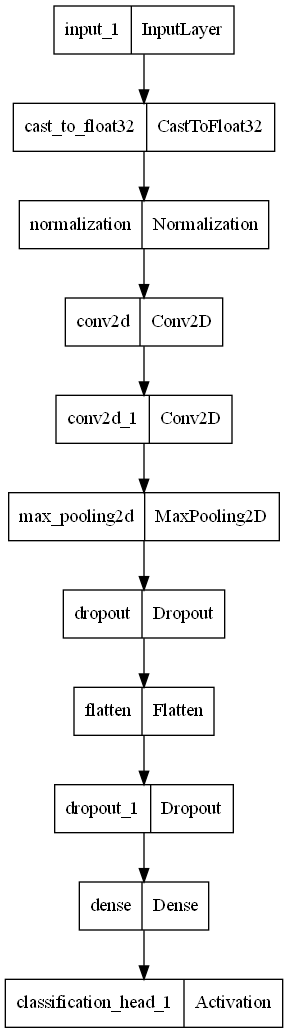

In [5]:
plot_model(loaded_model)

## 4. 모델 튜닝

### CNN 모델 튜닝

- CNN 모델의 경우 튜닝할 것이 max_trials로 정해져 있으며, 이는 최대 시도 회수로 epoch와는 다른 개념으로 사용된다.
- max_trials는 모델 구조에 따라 달라질 수 있으며, 최대 횟수 중 가장 좋은 모델을 최종적으로 선택하기 때문에 많이 한다고 해서 좋은 것이 아니다.

## 5. 모델 평가 및 해석

### CNN 모델 평가

In [11]:
# image 전처리 과정에서 시간이 걸리기 때문에 데이터셋 세팅 시 시간이 오래 걸린다
x_test = np.array([img_preprocess(p) for p in aic.test_df.name.values])
y_test = aic.test_df.outcome.values

In [13]:
# CNN 모델 평가
y_pred_ori = loaded_model.predict(x_test)
y_pred = [round(y[0], 0) for y in y_pred_ori]
print("accuracy = ", accuracy_score(y_test, y_pred))
print("recall = ", recall_score(y_test, y_pred))
print("precision = ", precision_score(y_test, y_pred))
print("f1 score = ", f1_score(y_test, y_pred))
# 모두 1.0으로 나타남 → Overfitting의 가능성이 있다

10/10 [==============================] - 5s 493ms/step
accuracy =  1.0
recall =  1.0
precision =  1.0
f1 score =  1.0


(array([ 15.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 276.]),
 array([1.3975915e-07, 9.9999867e-02, 1.9999960e-01, 2.9999933e-01,
        3.9999905e-01, 4.9999878e-01, 5.9999853e-01, 6.9999826e-01,
        7.9999799e-01, 8.9999771e-01, 9.9999744e-01], dtype=float32),
 <BarContainer object of 10 artists>)

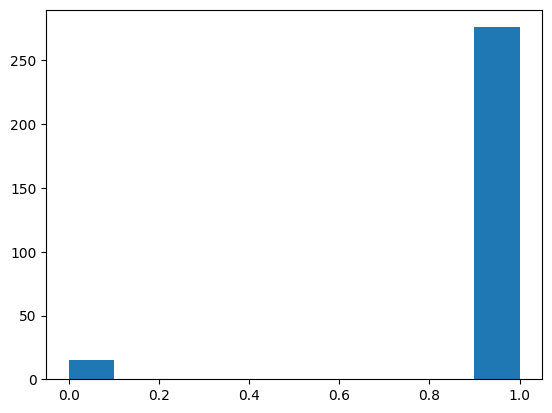

In [14]:
# CNN 모델 예측 원본 histogram
plt.hist(y_pred_ori)
# 데이터 예측 결과 극과 극으로 나누어짐
# Classification의 결과이기 때문

In [15]:
# CNN 모델 예측 및 RMSE 출력 코드
print('AutoKeras Model Predict :', y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
print('AutoKeras Model RMS :', rmse)
# 테스트 데이터셋 target 데이터와 비교하여 RMSE 계산 결과 약 0으로 나타남

AutoKeras Model Predict : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0

In [16]:
# CNN 모델 confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=[1,0])
print(conf_matrix)

[[276   0]
 [  0  15]]


In [17]:
# CNN 모델 roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
print(fpr, tpr, thresholds)

[0. 0. 1.] [0. 1. 1.] [2. 1. 0.]


<function matplotlib.pyplot.show(close=None, block=None)>

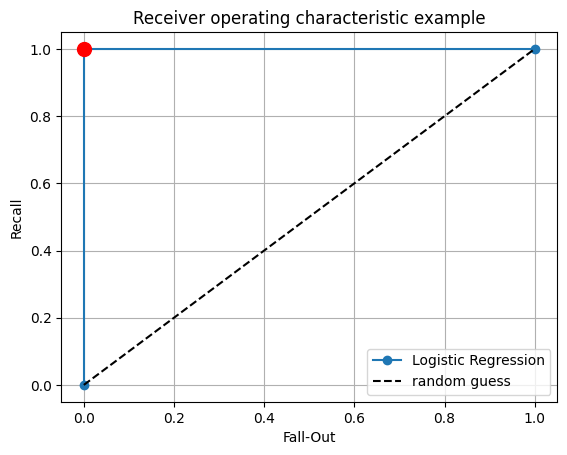

In [28]:
# CNN 모델 roc_curve 시각화
recall = conf_matrix[0][0]/(conf_matrix[0][0] + conf_matrix[0][1])
fallout = conf_matrix[1][0]/(conf_matrix[1][0] + conf_matrix[1][1])

plt.plot(fpr, tpr, 'o-', label="Logistic Regression")
plt.plot([0,1], [0,1], 'k--', label="random guess")
plt.plot([fallout], [recall], 'ro', ms=10)
plt.xlabel('Fall-Out')
plt.ylabel('Recall')
plt.title('Receiver operating characteristic example')
plt.grid()
plt.legend()

plt.show

In [29]:
# CNN 모델 검토 값 요약 정리
# 각 target value에 따른 결괏값 도출
print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00        15
     class 1       1.00      1.00      1.00       276

    accuracy                           1.00       291
   macro avg       1.00      1.00      1.00       291
weighted avg       1.00      1.00      1.00       291



### CNN 모델 해석

- Target Value가 0, 1로 나타나기 때문에 오차는 거의 없도록 학습이 진행된 것을 볼 수 있다.
- Input Data로 제품 Image 데이터를 입력했을 때, 나오는 출력값을 통해 어떠한 품질 결과가 나타나는지 확인할 수 있다.
- 이를 통해, 육안검사를 통해 진행하던 품질검사를 자동 진행하는 공정을 진행할 수 있다.